В этой тетрадке потребуется обучить классификатор изображений. В датасете 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.


Будем пробовать использовать библиотеку `pytorch_lightning`.

In [ ]:
!pip install pytorch_lightning
!pip install albumentations==0.4.6
# !pip install wandb


In [ ]:
import math
import os
import random
import sys
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import albumentations as A
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import cv2
import glob
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, ExponentialLR
from torchmetrics.functional import accuracy
from albumentations.pytorch import ToTensorV2
from pandas.core.common import flatten
from torch.utils.data import Dataset
from torchvision.models import regnet_y_128gf, RegNet_Y_128GF_Weights, vit_h_14, efficientnet_v2_m, efficientnet_v2_s, vit_b_16, efficientnet_b2, densenet121, regnet_y_16gf
from torchsummary import summary
from torchvision.models import resnet18, resnet50, convnext_large, convnext_tiny, efficientnet_v2_s, convnext_small, resnet152
from pytorch_lightning.tuner.tuning import Tuner

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(42)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2023-11-12 19:39:27--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2023-11-12 19:39:27--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc894ab93eeeebd808fe10cb6b91.dl.dropboxusercontent.com/cd/0/get/CHYj9xH4MFRcj_CBgn5rQuwbg8ecmTpXRDfWq4OaVRldLzbUuWn1TVHOoU-gnKtw72KjClqPXXE_8WTZOZ1CdR6nXjSLdOrJ0PMA7Um9qp1IfQowKj_ASiBCk4KcIpukLUmirKjZsDnJJejLypZOacPM/file?dl=1# [following]
--2023-11-12 19:39:27--  https://uc894ab93eeeebd808fe10cb6b91.dl.dropboxusercontent.com/cd/0/get/CHYj9xH4MFRcj_CBgn5rQuwbg8ecmTpXRDfWq4OaVRldLzbUuWn1TVHOoU-gnKtw72KjClqPXXE_8WTZOZ1CdR6nXjSLdOrJ0PMA7Um

### Подготовка данных

In [ ]:
device = 'cuda'

Попробовал различные аугментации для разнообразия тренировочной выборки - защита от переобучения

 https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

In [ ]:
import torchvision.transforms.v2 as v2

In [ ]:
seed_everything(42)
# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform = v2.Compose([
    # v2.PILToTensor(),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomErasing(p = 0.2),
    v2.RandomGrayscale(p = 0.2),
    # v2.RandomInvert(p = 0.2),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transform = v2.Compose([
    # v2.PILToTensor(),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# cutmix = v2.CutMix(num_classes=200, alpha = 0.1)
# mixup = v2.MixUp(num_classes=200, alpha = 0.9)
# cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
# def custom_collate_fn(batch):
#     return cutmix(*torch.utils.data.dataloader.default_collate(batch))
train_dataset = ImageFolder('dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
# collate_fn = custom_collate_fn


In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

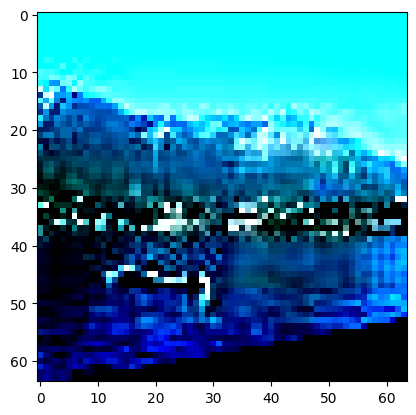

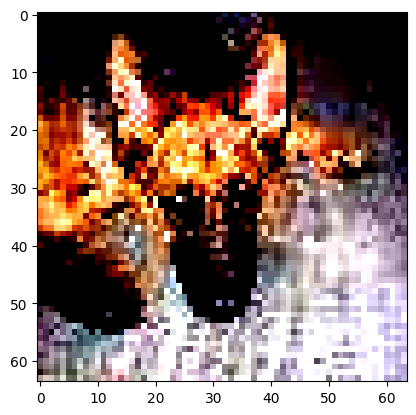

In [ ]:
for batch in train_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Без использования предобученных моделек.


In [ ]:
# class YourNet(nn.Module):
#     def __init__(self, num_classes):
#         super(YourNet, self).__init__()
#         self.resnet18 = resnet50(pretrained=False)
#         # Замените последний полносвязный слой для соответствия числу классов
#         self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

#     def _forward(self, x):
#         # Запуск нейронной сети ResNet-18
#         return self.resnet18(x)

#     def forward(self, images):
#         # Вызов _forward для передачи изображений через ResNet-18
#         return self._forward(images)

#     def get_accuracy(self, outputs, labels, reset=False):
#         # Ваш код для вычисления точности
#         with torch.no_grad():
#             predictions = torch.argmax(outputs, dim=1)
#             correct = (predictions == labels).sum().item()
#             accuracy = correct / len(labels)
#         return accuracy

In [ ]:
model = densenet121(weights = None, num_classes = 200)

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate, weight_decay):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        # self.save_hyperparameters()
        self.loss = nn.CrossEntropyLoss()
        self.cur_acc = 0
        self.cur_val_loss = 0
        self.batch_count = 0
        # self.wandb_logger = WandbLogger()

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=0, verbose=True)
        # lr_scheduler = CosineAnnealingLR(optimizer, T_max = 75, verbose = True)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'monitor': 'val_loss',
            }
        }

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True, logger=False)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='MULTICLASS', num_classes = 200)
        self.cur_acc += acc
        self.cur_val_loss += loss
        self.batch_count += 1
        return loss

    def on_validation_epoch_end(self):
        average_acc = self.cur_acc / self.batch_count
        average_loss = self.cur_val_loss / self.batch_count

        self.log("val_loss", average_loss, prog_bar=True)
        self.log("accuracy", average_acc, prog_bar=True)

In [ ]:
seed_everything(42)
module = YourModule(model, learning_rate=0.001, weight_decay = 0)
trainer = pl.Trainer(accelerator="gpu", max_epochs=75)
trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | DenseNet         | 7.2 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.635    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 1.2500e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 6.2500e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 3.1250e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00020: reducing learning rate of group 0 to 1.5625e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 7.8125e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 3.9063e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00023: reducing learning rate of group 0 to 1.9531e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00024: reducing learning rate of group 0 to 9.7656e-07.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 4.8828e-07.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00026: reducing learning rate of group 0 to 2.4414e-07.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00027: reducing learning rate of group 0 to 1.2207e-07.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00028: reducing learning rate of group 0 to 6.1035e-08.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00029: reducing learning rate of group 0 to 3.0518e-08.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 1.5259e-08.


### Валидация результатов задания

In [ ]:
trainer.save_checkpoint("model.ckpt")

In [ ]:
def evaluate_task(model, test_dataloader, device='cuda'):
    model = model.to(device)
    model.eval()
    accs = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            acc = accuracy(torch.argmax(outputs, dim=-1).long(), labels.long(), task='MULTICLASS', num_classes = 200)
        accs += acc
    accs = accs / len(test_dataloader)
    return accs

In [ ]:
# modelc = YourModule.load_from_checkpoint("model.ckpt")
seed_everything(42)

accs = evaluate_task(model, val_dataloader)
accs_cpu = accs.cpu().numpy()

print()
print(accs_cpu)


100%|██████████| 79/79 [00:07<00:00, 11.22it/s]


Оценка за это задание составит 10.00 баллов
0.48803404


## С использованием pre-trained моделей


In [ ]:
seed_everything(42)
# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform = v2.Compose([
    v2.Resize((236, 236)),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomErasing(p = 0.1),
    v2.RandomGrayscale(p = 0.2),
    v2.RandomInvert(p = 0.2),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transform = v2.Compose([
    # v2.PILToTensor(),
    v2.Resize((236, 236)),
    v2.CenterCrop(224),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# cutmix = v2.CutMix(num_classes=200, alpha = 0.1)
# # mixup = v2.MixUp(num_classes=200, alpha = 0.9)
# def custom_collate_fn(batch):
#     return cutmix(*torch.utils.data.dataloader.default_collate(batch))
train_dataset = ImageFolder('dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
# collate_fn = custom_collate_fn


### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, learning_rate):
        super().__init__()
        self.model = convnext_large(weights = "DEFAULT")
        self.learning_rate = learning_rate
        # self.save_hyperparameters()
        self.loss = nn.CrossEntropyLoss()
        self.cur_acc = 0
        self.cur_val_loss = 0
        self.batch_count = 0
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.classifier[-1] = nn.Sequential(
            nn.Linear(1536, 1000),
            nn.ReLU(),
            # nn.Dropout(p=0.3),
            nn.Linear(1000, 200),
        )

        for param in self.model.classifier[-1].parameters():
            param.requires_grad = True
        self.optimizer = torch.optim.Adam(self.model.classifier[-1].parameters(), lr=self.learning_rate)
        # self.lr_scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=0, verbose=True)
        self.lr_scheduler = ExponentialLR(self.optimizer, gamma = 0.1, verbose=True)
        # self.wandb_logger = WandbLogger()

    def forward(self, x):
        result = self.model(x)
        return result


    def configure_optimizers(self):
        return {
            'optimizer': self.optimizer,
            'lr_scheduler': {
                'scheduler': self.lr_scheduler,
                'monitor': 'val_loss',
            }
        }

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True, logger=False)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='MULTICLASS', num_classes = 200)
        self.cur_acc += acc
        self.cur_val_loss += loss
        self.batch_count += 1
        return loss

    def on_validation_epoch_end(self):
        average_acc = self.cur_acc / self.batch_count
        average_loss = self.cur_val_loss / self.batch_count

        self.log("val_loss", average_loss, prog_bar=True)
        self.log("accuracy", average_acc, prog_bar=True)

In [ ]:
seed_everything(42)
module = YourModule(learning_rate = 0.001)
trainer = pl.Trainer(accelerator="gpu", max_epochs=20)
trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Adjusting learning rate of group 0 to 1.0000e-03.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ConvNeXt         | 197 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.7 M     Trainable params
196 M     Non-trainable params
197 M     Total params
791.870   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

### Валидация результатов задания

In [ ]:
seed_everything(42)
accs = evaluate_task(module, val_dataloader)
accs_cpu = accs.cpu().numpy()

print()
print(f"Оценка за это задание составит {np.clip(10 * (accs_cpu - 0.5) / 0.34, 0, 10):.2f} баллов")
print(accs_cpu)



100%|██████████| 157/157 [04:03<00:00,  1.55s/it]


Оценка за это задание составит 10.00 баллов
0.8441481


# Отчёт об экспериментах



все модели которые есть в импорте я протестировал. я протестил практически все аугментации, кучу комбинации - и пришел к выводу, что особо сильного приросто она не дает, и в итоге использовал рандомную комбинацию трансформов. каким то боком в первом задании на фулл решает модель, которая в документации далеко не лучшая. я перебирал эти чертовы модели неделю, а в итоге малютка денснет оказалась в разы лучше(до нее мой максимум был 0.36 за 65 эпох).

второе задание - тут уже денснет не канает, пробовал efficientnet, resnet, regnet. остановился на convnext_large. сделал небольшой ресайз(не как в документации, так по 40 минут эпоха), обучаю - 0.74 с первой эпохи и особо не растет

пробую ресайз как по документации - 236 + кроп 224 - с первой же эпохи 0.833 по лайтнингу, 0.84+ по evaluate. Это победа